In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [3]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
!pwd


/home/nwoofter/sipm-analysis


## Example waveforms

In [5]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/*/'
glob.glob(data_dir)

['/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_60_light_laser_config_1_cond_ln_long_intensity_500/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_92_light_laser_config_1_cond_ln_intensity_1020/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1020/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_92_light_laser_config_1_cond_ln_intensity_1120/']

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/wave0.dat
51129 events


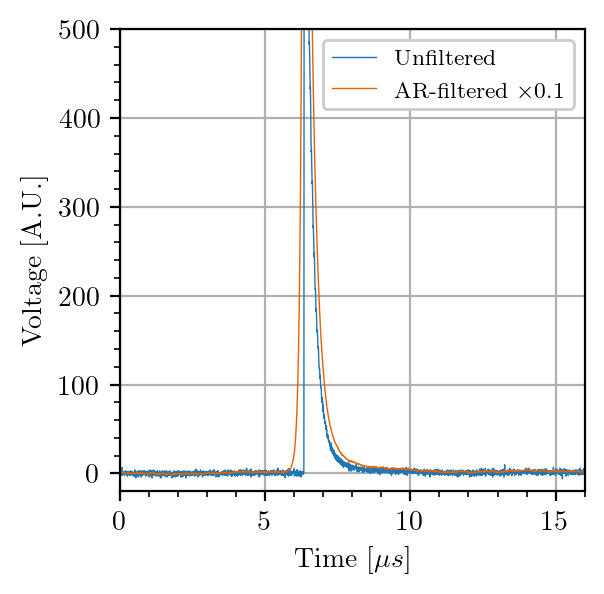

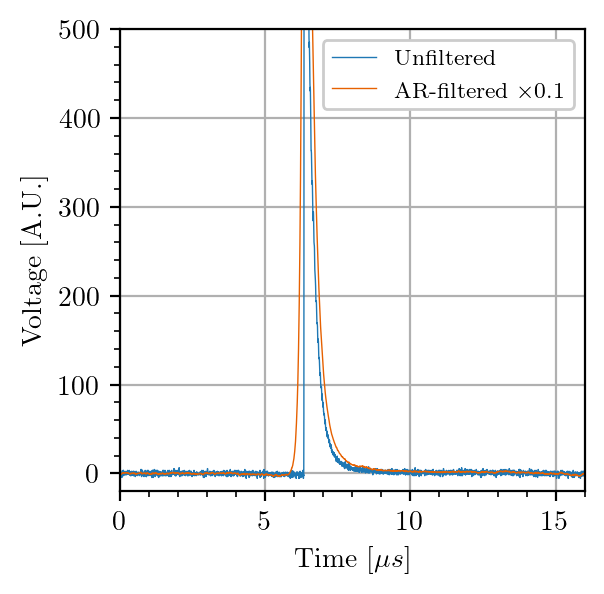

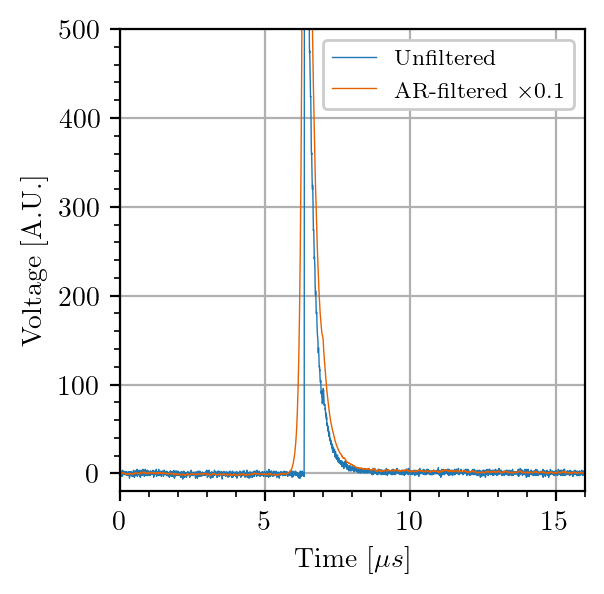

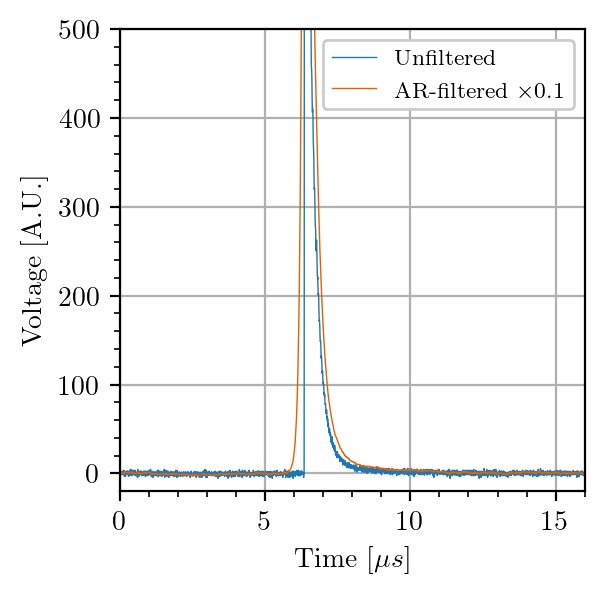

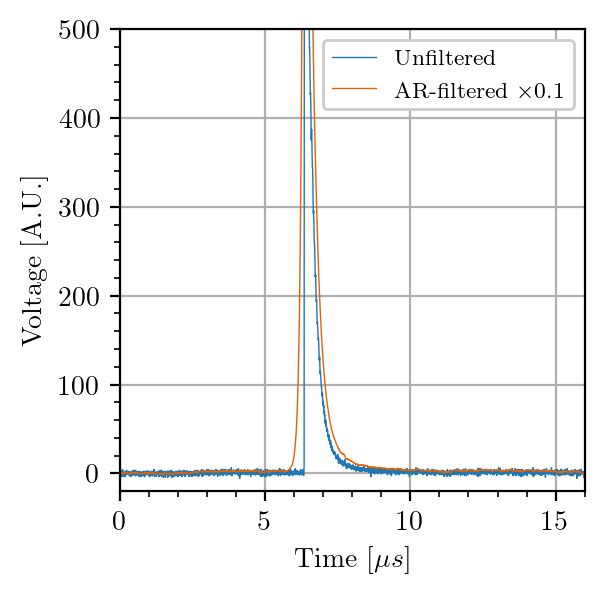

In [6]:
import sipm.recon.WaveformDataset as wfd
ch = 0
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/', pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-20, 500)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [4]:
# data folder
path = "/scratch/gpfs/nwoofter/results/"
data = {}
intensity = [1020, 1120]
channels = [0, 1, 2, 3]
voltages = [90,92]
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {}
        for volt in voltages:
            data[intn][ch][volt] = []
            files = glob.glob(f"{path}2023-06-07/*volt_{volt}*intensity_{intn}*[!_wf].h5")
            print(files)
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[intn][ch][volt].append(df)
            data[intn][ch][volt] = pd.concat(
                data[intn][ch][volt], ignore_index=True)
print('keys: ', list(data[1020][0][90].keys()))

['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_c

In [5]:
intn = 1020
ch = 0
volt = 90
data[intn][ch][volt]

,baseline_mean,baseline_rms,amplitude_trig,peakpos_trig,integral_2p00us
0,3835.932469,1.717480,374.117879,1588,2046.559345
1,3835.933834,1.715546,366.615285,1587,1458.255116
2,3835.491132,1.630286,385.495052,1587,1572.477490
3,3835.366985,1.618987,427.285934,1586,1576.162347
4,3834.612551,1.785176,746.108748,1589,4145.401091
...,...,...,...,...,...
50794,3835.743520,1.668168,367.198541,1589,1461.195089
50795,3836.272851,1.725908,781.678605,1587,3027.154161
50796,3836.598909,1.968746,697.647699,1590,2739.443383
50797,3834.684857,1.612199,375.874031,1587,1188.276944


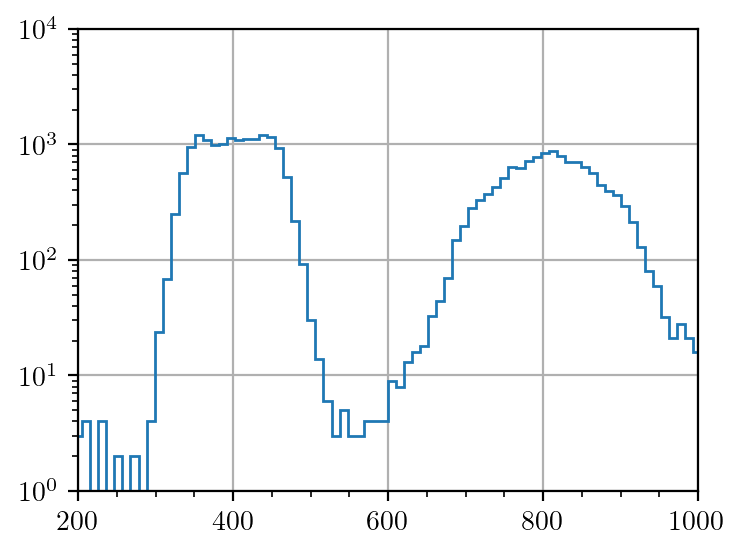

In [6]:
intn = 1020
ch = 0
volt = 90


plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.xlim(200, 1000)
plt.yscale('log')

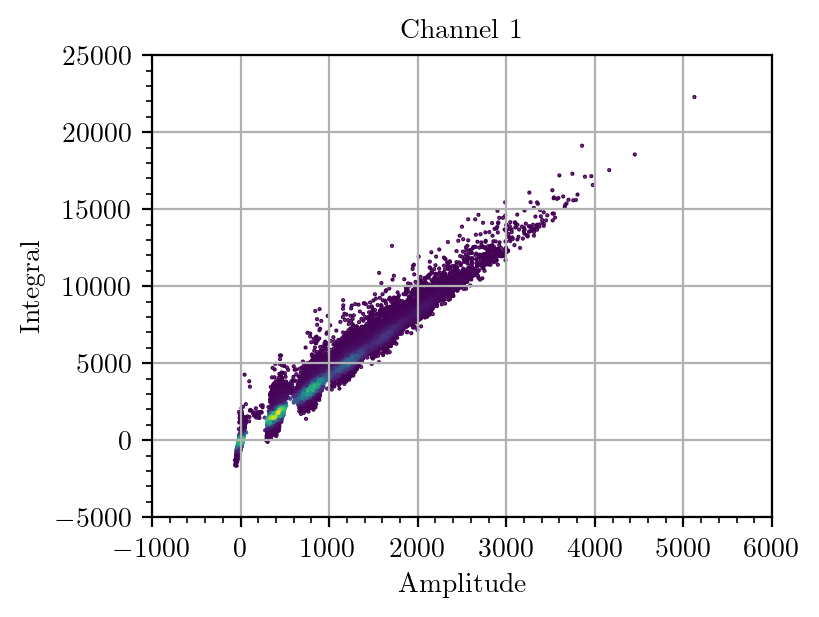

In [8]:
from scipy.stats import gaussian_kde

intn = 1020
ch = 0
volt = 90

amp = data[intn][ch][volt]['amplitude_trig']
integ = data[intn][ch][volt]['integral_2p00us']


xy = np.vstack([amp, integ])
z = gaussian_kde(xy)(xy)

plt.scatter(amp, integ, c=z, s=0.25)
plt.xlabel('Amplitude')
plt.ylabel('Integral')
plt.title('Channel 1')
plt.minorticks_on()
plt.grid()

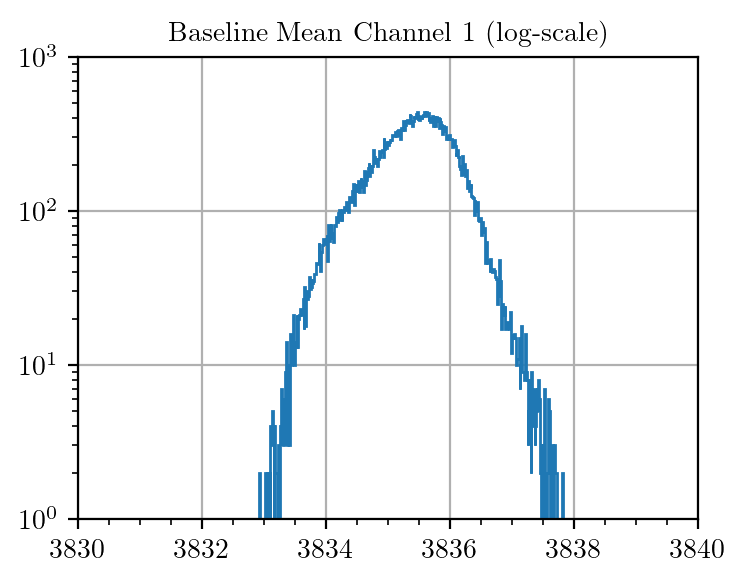

In [11]:
intn = 1020
ch = 0
volt = 90


plt.hist(data[intn][ch][volt]['baseline_mean'], bins=500, histtype='step')
plt.minorticks_on()
plt.title('Baseline Mean Channel 1 (log-scale)')
plt.yscale('log')
plt.grid()

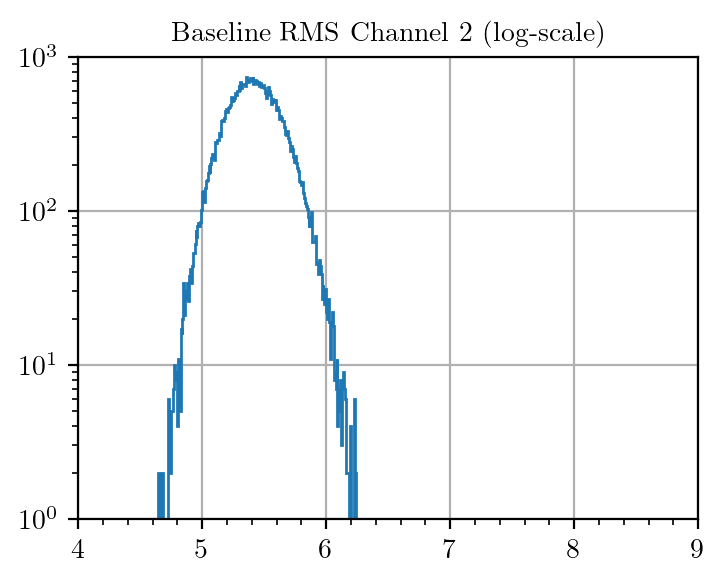

In [25]:
intn = 1020
ch = 1
volt = 90


plt.hist(data[intn][ch][volt]['baseline_rms'], bins=500, histtype='step')
plt.minorticks_on()
plt.title('Baseline RMS Channel 2 (log-scale)')
plt.yscale('log')
#plt.xlim(2, 3)
plt.grid()

<function matplotlib.pyplot.yscale(value, **kwargs)>

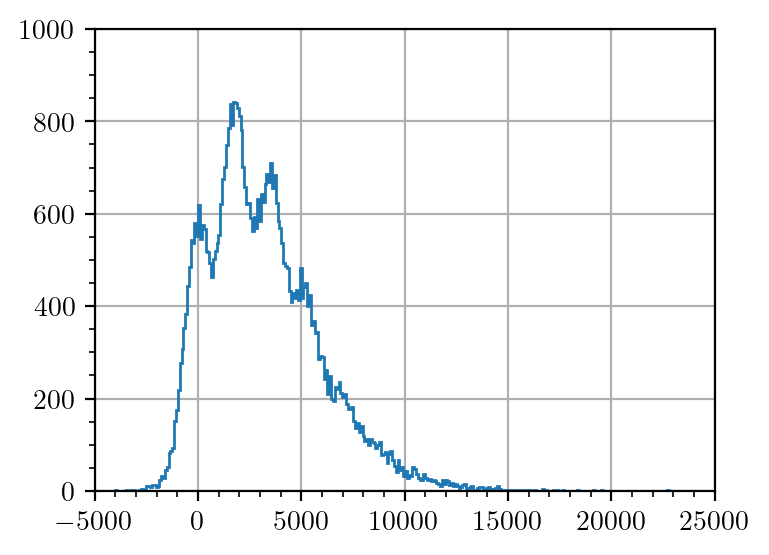

In [13]:
intn = 1020
ch = 0
volt = 90

integral = data[intn][ch][volt]['integral_5p00us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 300 and x < 500:
        pk2.append(integral[i])
    i += 1
    

plt.hist(integral, bins=300, histtype='step')
plt.minorticks_on()
plt.grid()
plt.yscale

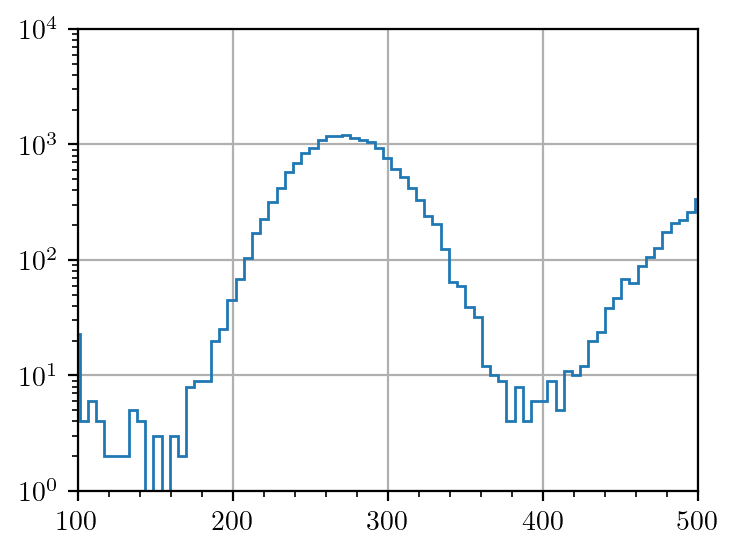

In [14]:
intn = 1020
ch = 1
volt = 90


plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.xlim(100, 500)
plt.yscale('log')

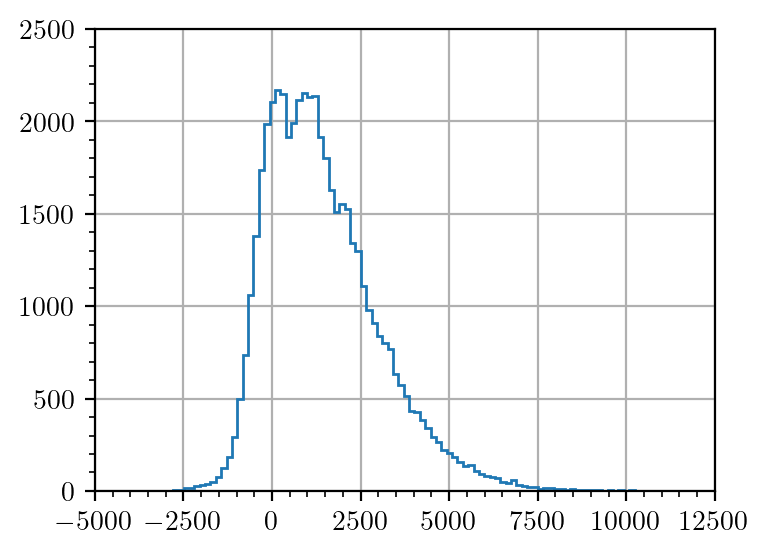

In [15]:
intn = 1020
ch = 1
volt = 90

integral = data[intn][ch][volt]['integral_5p00us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 160 and x < 360:
        pk2.append(integral[i])
    i += 1

plt.hist(integral, bins=100, histtype='step')
plt.minorticks_on()
plt.grid()

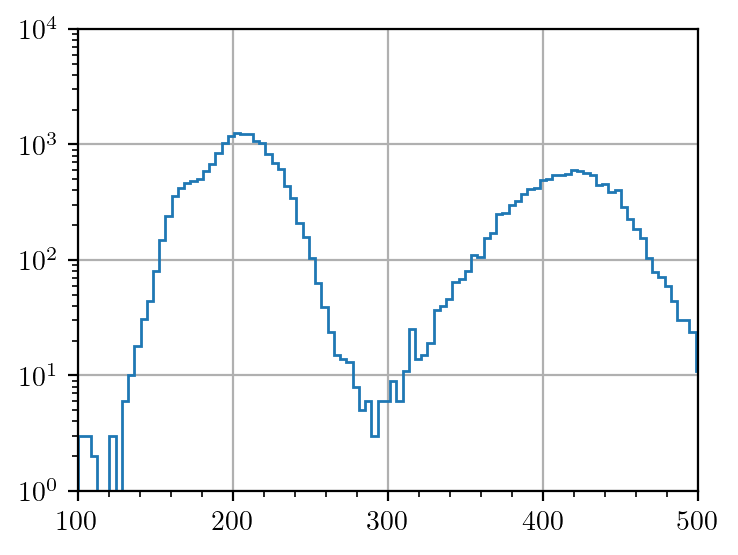

In [16]:
intn = 1020
ch = 2
volt = 90


plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.xlim(100, 500)
plt.yscale('log')

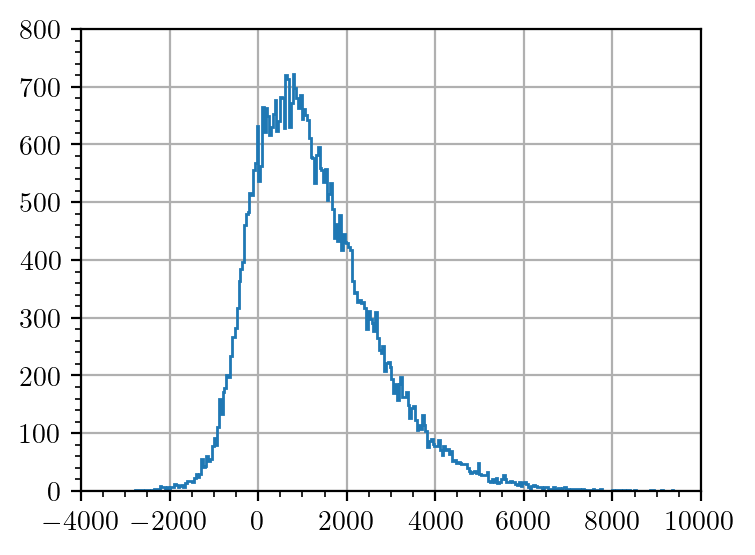

In [17]:
intn = 1020
ch = 2
volt = 90

integral = data[intn][ch][volt]['integral_5p00us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 140 and x < 280:
        pk2.append(integral[i])
    i += 1

plt.hist(integral, bins=300, histtype='step')
plt.minorticks_on()
plt.grid()

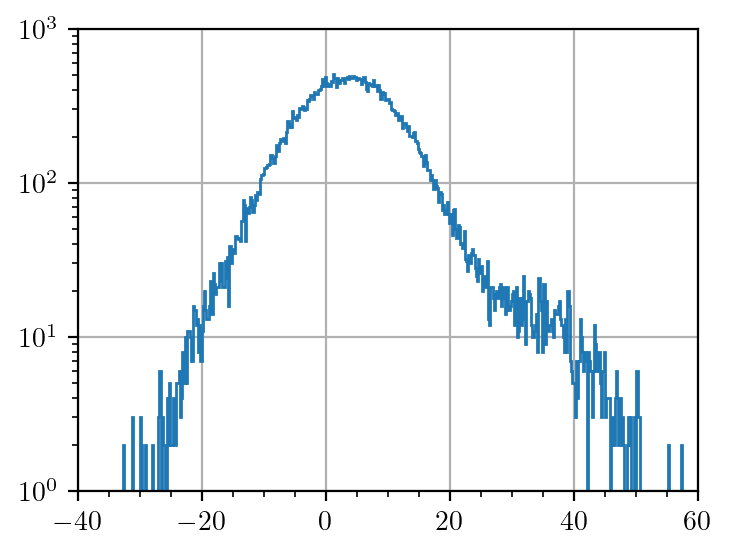

In [18]:
intn = 1020
ch = 3
volt = 90


plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.yscale('log')

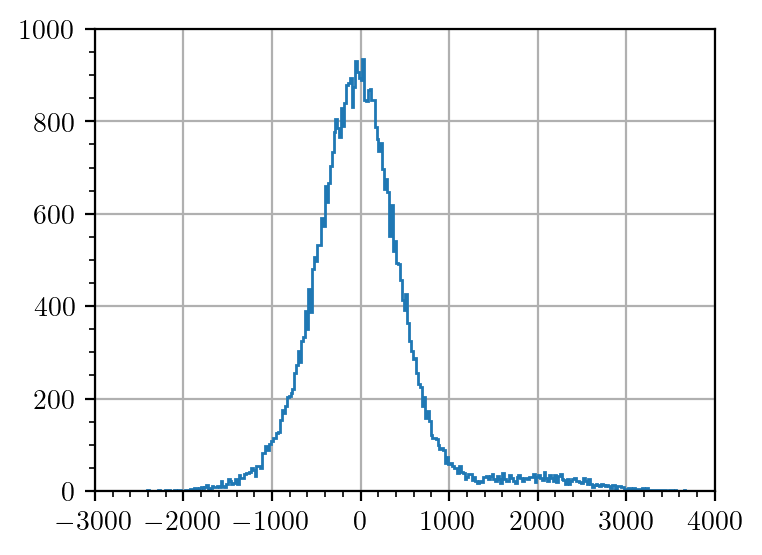

In [19]:
intn = 1020
ch = 3
volt = 90

integral = data[intn][ch][volt]['integral_5p00us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 120 and x < 300:
        pk2.append(integral[i])
    i += 1

plt.hist(data[intn][ch][volt]['integral_5p00us'], bins=300, histtype='step')
plt.minorticks_on()
plt.grid()